## Drifter movies
This notebook demonstrates animating drifters, model surface currents, and GEM winds. You may wish to export the main function to a module and run on salish if your animation period is longer than 2 weeks.
### Drifter deployments (2016)
   1. `apr 18 - apr 29 ( 8 tracks)`
   2. `may 02 - may 07 ( 2 tracks)`
   3. `may 10 - may 22 (12 tracks)`
   4. `may 24 - jun 08 ( 9 tracks)`
   5. `jun 06 - jun 18 ( 9 tracks)`
   6. `jun 14 - jul 08 ( 4 tracks)`
   7. `jun 28 - jul 13 ( 6 tracks)`
   8. `jul 19 - aug 02 (13 tracks)`
   9. `aug 30 - sep 06 ( 6 tracks)`

In [1]:
from salishsea_tools import nc_tools, data_tools, visualisations, viz_tools
from collections     import OrderedDict
from matplotlib      import pyplot, animation, rcParams, patches
from dateutil        import parser
import datetime
import os
import xarray
import numpy as np
import progressbar

%matplotlib inline
rcParams.update({'font.size': 12})
rcParams["axes.formatter.useoffset"] = False

Create animation object ...
Save animation ...


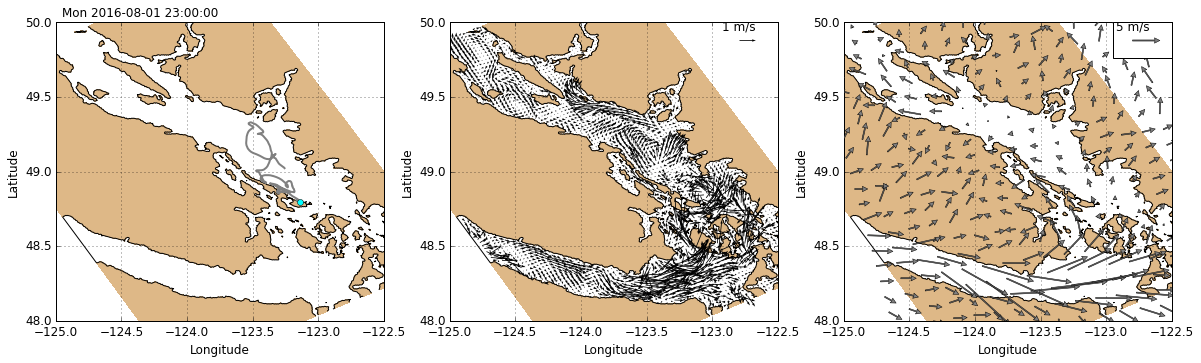

In [4]:
timerange = ['2016 Aug 1 00:00', '2016 Aug 2 00:00']
drifter_animation(timerange)

In [3]:
def drifter_animation(timerange):
    """
    """
    
    print('Loading results ...')
    # Timerange
    starttime, endtime = map(parser.parse, timerange)
    frames = int((endtime - starttime).total_seconds()/3600)
    
    # Load and process results
    GEM  = nc_tools.load_GEM_from_erddap(timerange,
            window=[250000, 437500, 212500, 462500])
    NEMO = nc_tools.load_NEMO_from_erddap(timerange, depth=[0, 1],
            window=[None, None, 200, 700], fields=['u_vel', 'v_vel']).isel(depth=0)
    DRIFTERS = data_tools.load_drifters(deployments=range(1, 10))
    NEMO['u_vel'] = viz_tools.unstagger_xarray(NEMO.u_vel, 'gridX')
    NEMO['v_vel'] = viz_tools.unstagger_xarray(NEMO.v_vel, 'gridY')
    NEMO['u_vel'], NEMO['v_vel'] = viz_tools.rotate_vel(NEMO.u_vel, NEMO.v_vel)
    
    print('Making figure ...')
    # Create figure
    fig, ax   = pyplot.subplots(1, 3, figsize=(20, 10))
    L_drift   = OrderedDict()
    palette   = ['blue', 'teal', 'cyan', 'green', 'lime', 'darkred', 'red',
                 'orange', 'magenta', 'purple', 'black', 'dimgray', 'saddlebrown']

    # Plot Drifters
    visualisations.create_figure(ax[0], NEMO.isel(time=0))
    for deployment in DRIFTERS.items():
        for index, drifter in enumerate(deployment[1].items()):
            drift_start, drift_end = map(nc_tools.xarraytime_to_datetime, drifter[1].time[[0, -1]])
            if (starttime - drift_end).total_seconds() > 3600:
                timebound = drift_start - datetime.timedelta(hours=1)
            else:
                timebound = starttime
            L_drift[drifter[0]] = visualisations.plot_drifters(
                ax[0], drifter[1].sel(time=slice(None, timebound)), color=palette[index])

    # Plot surface currents
    visualisations.create_figure(ax[1], NEMO.isel(time=0))
    Q_vel = visualisations.plot_velocity(ax[1], 'NEMO', NEMO.sel(time=starttime, method='nearest'))
    Qkey = pyplot.quiverkey(Q_vel, 0.88, 0.94, 1, '1 m/s', coordinates='axes')

    # Plot Wind
    visualisations.create_figure(ax[2], NEMO.isel(time=0))
    Q_wind = visualisations.plot_velocity(ax[2], 'GEM', GEM.sel(time=starttime, method='nearest'),
                        color='gray', scale=60, linewidth=0.5, headwidth=5, mask=False)
    lbox = ax[2].add_patch(patches.Rectangle((0.82, 0.88), 0.18, 0.12,
                        facecolor='white', transform=ax[2].transAxes, zorder=10))
    Qkey = pyplot.quiverkey(Q_wind, 0.88, 0.94, 5, '5 m/s', coordinates='axes').set_zorder(11)

    # Add timestamp
    TXT_time = ax[0].text(0.02, 1.02, starttime.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax[0].transAxes)

    # ------------ ANIMATION CODE ------------------

    # Create dict of objects to be modified with each timestep
    PLOT_OBJS = {'Q_vel': Q_vel, 'Q_wind': Q_wind, 'L_drift': L_drift, 'TXT_time': TXT_time}

    # Create local function that updates these objects (iterates over time integer t)
    def next_frame(t, PLOT_OBJS):

        # Step time index forward
        time_ind = starttime + datetime.timedelta(hours=t)
        
        # Update drifter tracks (one at a time)
        for deployment in DRIFTERS.items():
            for index, drifter in enumerate(deployment[1].items()):
                drift_start, drift_end = map(nc_tools.xarraytime_to_datetime, drifter[1].time[[0, -1]])
                if (time_ind - drift_end).total_seconds() > 3600:
                    timebound = drift_start - datetime.timedelta(hours=1)
                else:
                    timebound = time_ind
                PLOT_OBJS['L_drift'][drifter[0]] = visualisations.plot_drifters(
                    ax[0], drifter[1].sel(time=slice(None, timebound)),
                    DRIFT_OBJS=PLOT_OBJS['L_drift'][drifter[0]], color=palette[index])

        # Update surface currents
        PLOT_OBJS['Q_vel']  = visualisations.plot_velocity(
            ax[1], 'NEMO', NEMO.sel(time=time_ind, method='nearest'), Q=PLOT_OBJS['Q_vel'])

        PLOT_OBJS['Q_wind'] = visualisations.plot_velocity(
            ax[2], 'GEM',  GEM.sel( time=time_ind, method='nearest'), Q=PLOT_OBJS['Q_wind'], mask=False)

        # Update timestamp
        PLOT_OBJS['TXT_time'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))

        return PLOT_OBJS
    
    print('Create animation object ...')
    # Call the animation function (create animation object)
    ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=frames)
    
    print('Save animation ...')
    # Save the animation
    ANI.save('/ocean/bmoorema/research/MEOPAR/analysis-ben/visualization/filename.mp4',
             writer=animation.FFMpegWriter(fps=12, bitrate=10000))

## Fluxes along the Sunshine Coast
We can observe a northward current along the sunshine coast that changes in strength at subtidal frequencies. Let's analyze the flux through a cross-strait transect.

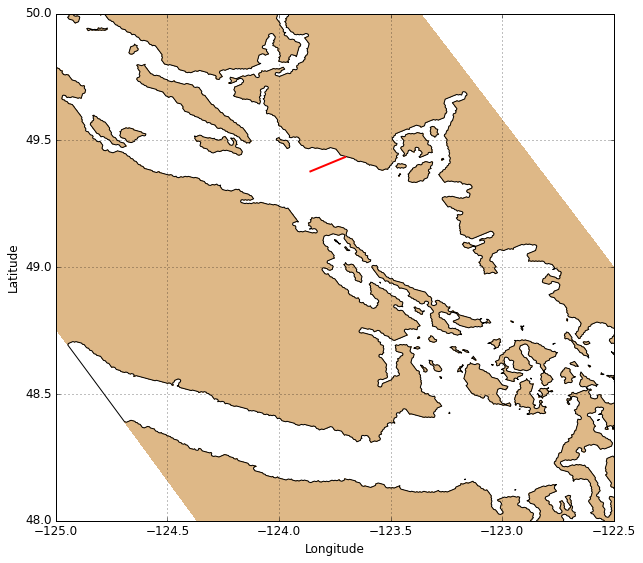

In [32]:
timerange = ['2016 Aug 1 00:00', '2016 Aug 1 01:00']
NEMO = nc_tools.load_NEMO_from_erddap(timerange, depth=[0, 1], fields=['v_vel']).isel(depth=0)
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
visualisations.create_figure(ax, NEMO.isel(time=0))
ax.plot(NEMO.longitude.sel(gridX=slice(245, 275), gridY=520), NEMO.latitude.sel(gridX=slice(245, 275), gridY=520),
        'r-', linewidth=2)
pyplot.show()

In [52]:
# Timerange
timerange = ['2015 Sep 1 00:00', '2016 Sep 1 00:00']

# Open datasets
PA = xarray.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnPointAtkinsonSSH15mV1'
                        ).sel(time=slice(timerange[0], timerange[1])).isel(longitude=0, latitude=0)
NEMO = nc_tools.load_NEMO_from_erddap(timerange, depth=[0, 1],
            window=[245, 275, 520, 520], fields=['v_vel']).isel(gridY=0, depth=0)

# Calculate ssh derivative and flux
dSSHdt = PA.ssh.diff('time')/900
V_flux = NEMO.v_vel.sum(dim='gridX')*500

# Resample variables
dSSHdt_h = dSSHdt.resample('H', 'time')
V_flux_h = V_flux.resample('H', 'time')

###Full Year (Sep 2015 to Sep 2016)

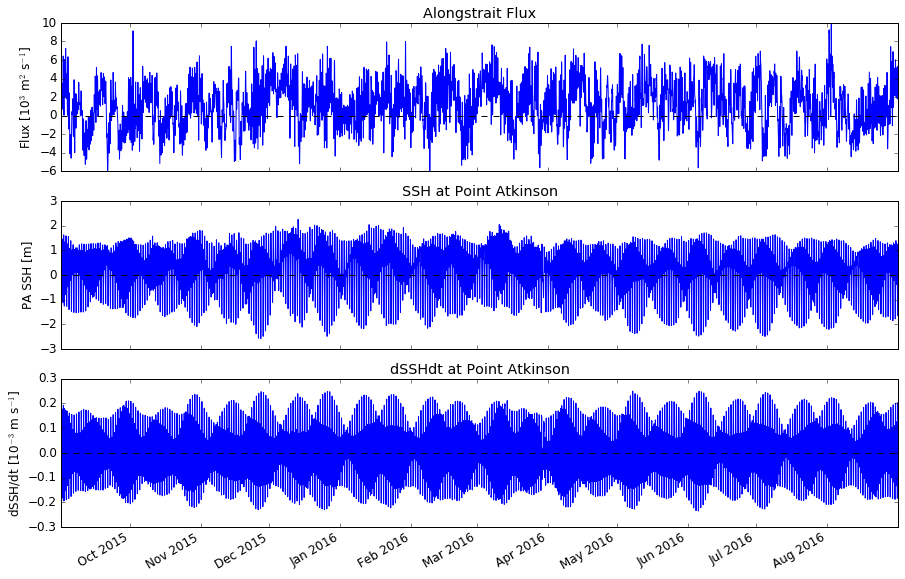

In [55]:
fig, ax = pyplot.subplots(3, 1, figsize=(15, 10))

ax[0].plot(V_flux.time, V_flux/1e3)
ax[0].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[0].set_ylabel('Flux [10$^3$ m$^2$ s$^{-1}$]')
ax[0].set_title('Alongstrait Flux')

PA.ssh.plot(ax=ax[1])
ax[1].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[1].set_ylabel('PA SSH [m]')
ax[1].set_title('SSH at Point Atkinson')

ax[2].plot(dSSHdt.time, dSSHdt*1e3)
ax[2].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[2].set_ylabel('dSSH/dt [10$^{-3}$ m s$^{-1}$]')
ax[2].set_title('dSSHdt at Point Atkinson')

pyplot.show()

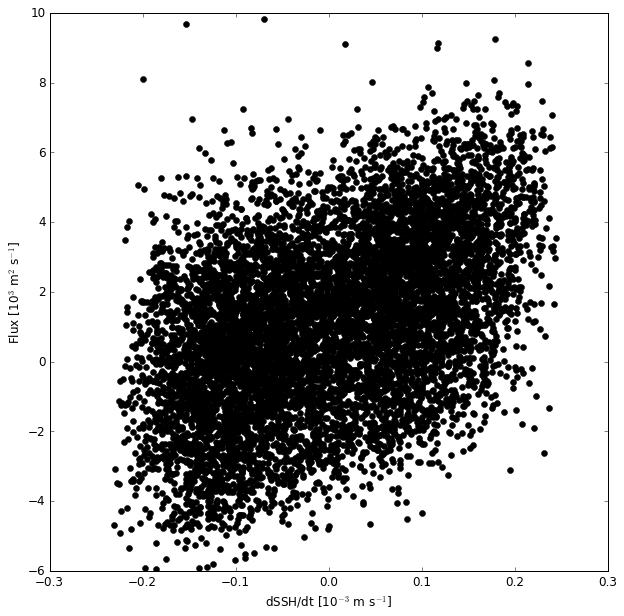

In [54]:
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
ax.plot(dSSHdt_h*1e3, V_flux_h/1e3, 'ko')
ax.set_xlabel('dSSH/dt [10$^{-3}$ m s$^{-1}$]')
ax.set_ylabel('Flux [10$^3$ m$^2$ s$^{-1}$]')

pyplot.show()

###January 2016

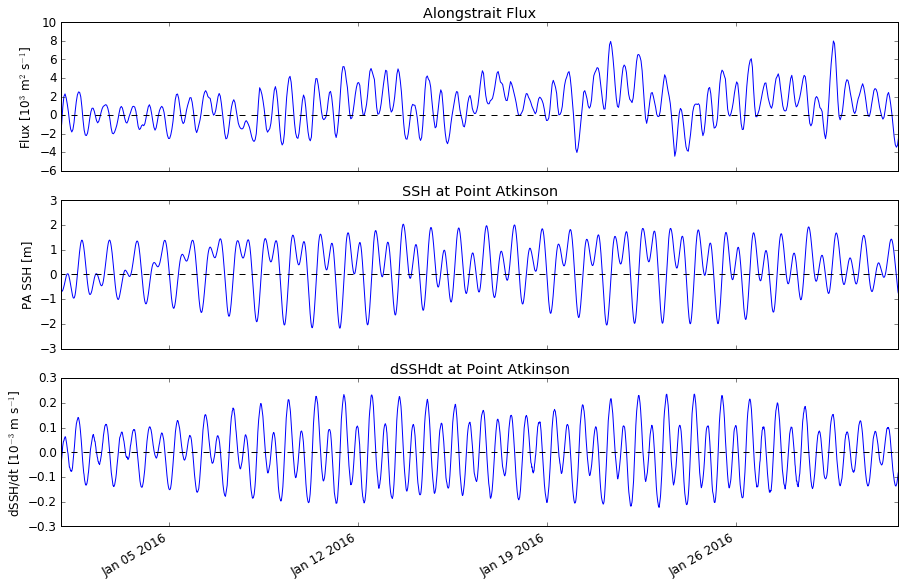

In [73]:
fig, ax = pyplot.subplots(3, 1, figsize=(15, 10))
start, end = map(parser.parse, ['2016 Jan 1 00:00', '2016 Feb 1 00:00'])

ax[0].plot(V_flux.time, V_flux/1e3)
ax[0].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[0].set_ylabel('Flux [10$^3$ m$^2$ s$^{-1}$]')
ax[0].set_title('Alongstrait Flux')
ax[0].set_xlim([start, end])

PA.ssh.plot(ax=ax[1])
ax[1].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[1].set_ylabel('PA SSH [m]')
ax[1].set_title('SSH at Point Atkinson')
ax[1].set_xlim([start, end])

ax[2].plot(dSSHdt.time, dSSHdt*1e3)
ax[2].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[2].set_ylabel('dSSH/dt [10$^{-3}$ m s$^{-1}$]')
ax[2].set_title('dSSHdt at Point Atkinson')
ax[2].set_xlim([start, end])

pyplot.show()

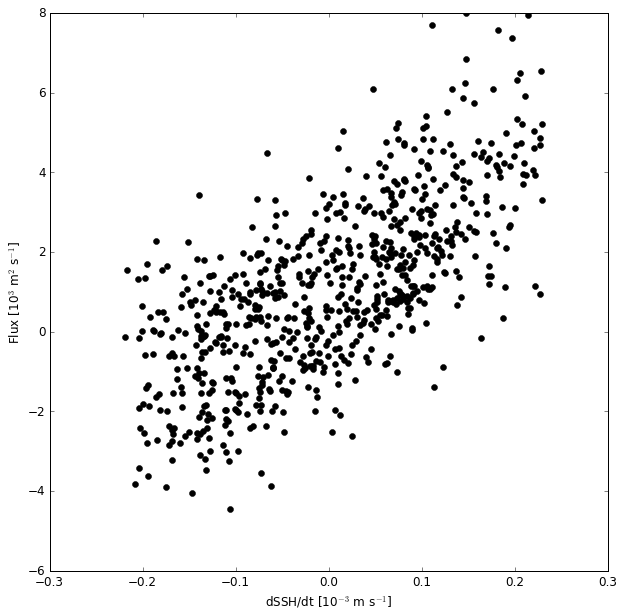

In [72]:
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
timeslice = slice('2016 Jan 1 00:00', '2016 Feb 1 00:00')

ax.plot(dSSHdt_h.sel(time=timeslice)*1e3, V_flux_h.sel(time=timeslice)/1e3, 'ko')
ax.set_xlabel('dSSH/dt [10$^{-3}$ m s$^{-1}$]')
ax.set_ylabel('Flux [10$^3$ m$^2$ s$^{-1}$]')

pyplot.show()

###Jun 2016

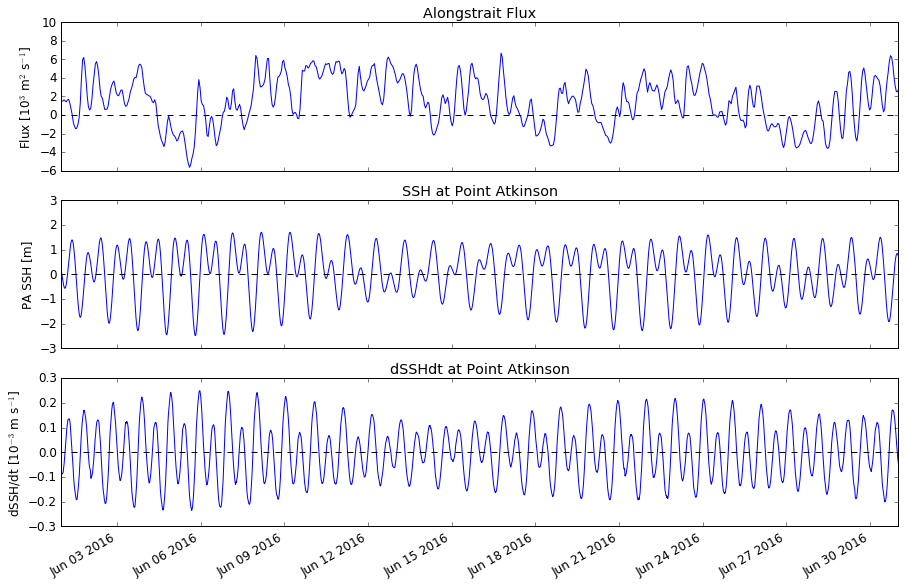

In [74]:
fig, ax = pyplot.subplots(3, 1, figsize=(15, 10))
start, end = map(parser.parse, ['2016 Jun 1 00:00', '2016 Jul 1 00:00'])

ax[0].plot(V_flux.time, V_flux/1e3)
ax[0].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[0].set_ylabel('Flux [10$^3$ m$^2$ s$^{-1}$]')
ax[0].set_title('Alongstrait Flux')
ax[0].set_xlim([start, end])

PA.ssh.plot(ax=ax[1])
ax[1].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[1].set_ylabel('PA SSH [m]')
ax[1].set_title('SSH at Point Atkinson')
ax[1].set_xlim([start, end])

ax[2].plot(dSSHdt.time, dSSHdt*1e3)
ax[2].plot([V_flux.time[0].values, V_flux.time[-1].values], [0, 0], 'k--')
ax[2].set_ylabel('dSSH/dt [10$^{-3}$ m s$^{-1}$]')
ax[2].set_title('dSSHdt at Point Atkinson')
ax[2].set_xlim([start, end])

pyplot.show()

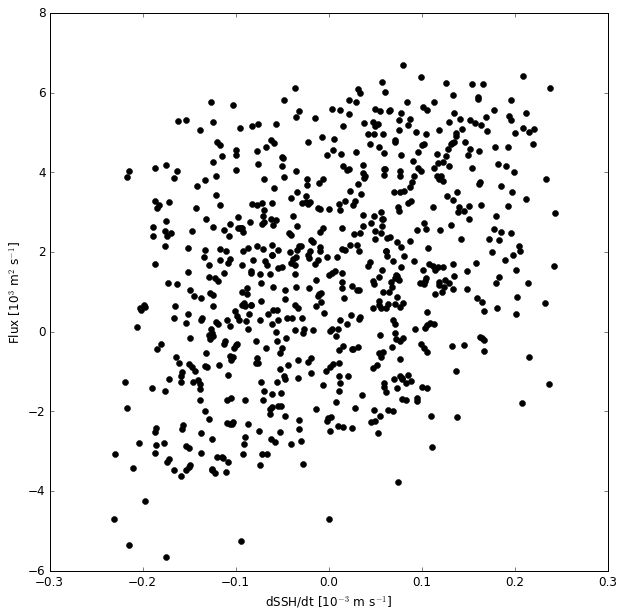

In [75]:
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
timeslice = slice('2016 Jun 1 00:00', '2016 Jul 1 00:00')

ax.plot(dSSHdt_h.sel(time=timeslice)*1e3, V_flux_h.sel(time=timeslice)/1e3, 'ko')
ax.set_xlabel('dSSH/dt [10$^{-3}$ m s$^{-1}$]')
ax.set_ylabel('Flux [10$^3$ m$^2$ s$^{-1}$]')

pyplot.show()